# 📊 Model Evaluation Notebook – Fire Detection Project

This notebook evaluates trained **image classification models** on either the:

- ✅ **D-Fire outdoor real-world test set** (used for Phases 1 and 2), or  
- ✅ **PLOS ONE indoor real-world test set** (used for Phase 3A domain shift testing)

The test set can be selected at runtime using the `TEST_SET` variable.

It supports evaluation of:
- ✅ Real-only models (e.g., `resnet_real_100.pt`, `resnet_real_100_ft.pt`)
- ✅ Synthetic-only models (e.g., `resnet_synthetic_100.pt`, `resnet_synthetic_100_ft.pt`)
- ✅ Mixed real/synthetic models (e.g., `resnet_mixed_50syn_50real.pt`, `resnet_mixed_50syn_50real_ft.pt`)
- ✅ Fine-tuned variants trained using unfreezing (e.g., layer4 + fc)

Evaluation includes:
- Computing **core classification metrics**: Accuracy, Precision, Recall, F1-score
- Generating a **confusion matrix** and **classification report**
- Plotting a **ROC curve** and calculating AUC score
- Saving results for inclusion in the dissertation report

📁 Output Files:
- `/results/metrics/` → Evaluation summaries (`.txt`)
- `/figures/roc_curves/` → ROC curve plots (`.png`)
- `/figures/confusion_matrices/` → Confusion matrices (`.png`)

Output filenames will include a suffix (`_dfire` or `_plos`) to indicate which test set was used.

---

## ⚙️ Usage Instructions

1. Set the `model_filename` and `TEST_SET` variables at the top of the notebook (e.g., `"resnet_real_100.pt"` and `"dfire"` or `"plos"`)
2. Ensure the model is present in the `/models/` directory
3. Run the notebook from top to bottom to:
   - Load the model
   - Evaluate on the selected test set
   - Save plots and metrics for later reporting

---

## 🔥 Roadmap Alignment

| Phase      | Evaluation Target                        | Status         |
|------------|------------------------------------------|----------------|
| Phase 1    | Compare frozen ResNet-50 models          | ✅ Done         |
| Phase 2    | Evaluate fine-tuned variants             | ✅ Done         |
| Phase 3A   | Outdoor → Indoor domain shift (PLOS ONE) | 🔄 In Progress  |
| Phase 3B   | Indoor synthetic → Outdoor (D-Fire test) | 🔜 Planned      |
| Phase 4    | Indoor deployment (Indoor test set)      | 🔜 Planned      |

🧠 **Note**: This notebook now supports both **D-Fire** and **PLOS ONE** test sets. Make sure to set the correct test dataset before running evaluations.


## 📦 Notebook Setup: Mount Drive & Clone GitHub Repo

This cell ensures the notebook is reproducible in any new Colab session by:

- Mounting your Google Drive (to access datasets, secrets, and checkpoints)
- Loading your GitHub token from Drive
- Cloning the fire-detection-dissertation repository
- Navigating into the correct folder
- Setting Git identity for future commits

⚠️ **Note:** This cell must be run every time you open this notebook in a new Colab session.


In [1]:
# 🔧 Minimal Colab setup for any working notebook

# 1. Mount Google Drive
import os
from google.colab import drive
if not os.path.ismount("/content/drive"):
    drive.mount("/content/drive")

# 2. Load GitHub token securely from Drive
token_path = "/content/drive/MyDrive/fire-detection-dissertation/secrets/github_token.txt"
with open(token_path, "r") as f:
    token = f.read().strip()

# 3. Clone the GitHub repo (force fresh clone for safety)
username = "Misharasapu"
repo = "fire-detection-dissertation"
clone_url = f"https://{token}@github.com/{username}/{repo}.git"
repo_path = f"/content/{repo}"

# Optional: Remove old clone (safe to rerun)
!rm -rf {repo_path}

# Clone fresh and move into the repo
%cd /content
!git clone {clone_url}
%cd {repo}

# 4. Set Git identity (required in Colab sessions)
!git config --global user.name "Misharasapu"
!git config --global user.email "misharasapu@gmail.com"


Mounted at /content/drive
/content
Cloning into 'fire-detection-dissertation'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 112 (delta 54), reused 78 (delta 24), pack-reused 0 (from 0)
Receiving objects: 100% (112/112), 4.22 MiB | 2.23 MiB/s, done.
Resolving deltas: 100% (54/54), done.
/content/fire-detection-dissertation


## 🧪 Step 1: Load the Evaluation Test Dataset (D-Fire or PLOS ONE)

In this step, we load the appropriate **hold-out test dataset** depending on the evaluation target:

- 🏞️ **D-Fire** – outdoor industrial dataset (standard benchmark for Phases 1–2 and Phase 3B)
- 🏠 **PLOS ONE** – indoor fire dataset (Phase 3A target for domain shift testing)

The test dataset to load is controlled via the `test_dataset_source` variable (`"D_FIRE"` or `"PLOS_ONE"`).  
All images are preprocessed using the same pipeline as in training: resized to 224×224 and converted to PyTorch tensors.

We use the unified `FireClassificationDataset` class, which handles label logic based on the dataset type (`real`, `plos`, or `synthetic`).

Maintaining consistent preprocessing and evaluation logic ensures fair comparison across all phases.


In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from utils.fire_classification_dataset import FireClassificationDataset

# 🔧 Choose test dataset source: "D_FIRE" or "PLOS_ONE"
test_dataset_source = "PLOS_ONE"  # Change to "PLOS_ONE" for indoor evaluation

# ✅ Set image and label directories based on the selected test dataset
if test_dataset_source == "D_FIRE":
    test_image_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/D-Fire/test/images"
    test_label_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/D-Fire/test/labels"
    dataset_type = "real"
elif test_dataset_source == "PLOS_ONE":
    test_image_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/PLOS_ONE/test/images"
    test_label_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/PLOS_ONE/test/labels"
    dataset_type = "plos"
else:
    raise ValueError("❌ Invalid test_dataset_source. Choose either 'D_FIRE' or 'PLOS_ONE'.")

# ✅ Define preprocessing transforms (same as used in training)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ✅ Load test dataset and create DataLoader
test_dataset = FireClassificationDataset(
    image_dir=test_image_dir,
    label_dir=test_label_dir,
    transform=test_transforms,
    dataset_type=dataset_type
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# ✅ Add suffix for naming saved results (used in Steps 3–5)
test_suffix = f"_{test_dataset_source}"


print(f"✅ Loaded {test_dataset_source} test set with {len(test_dataset)} images.")


✅ Loaded PLOS_ONE test set with 500 images.


## 🧠 Step 2: Load the Trained ResNet-50 Model

In this step, we load a trained **ResNet-50** model from a saved checkpoint stored in the `/models/` directory. This model may have been trained on real, synthetic, or mixed datasets, but the final architecture is standardised for binary classification (fire vs. no fire).

We create a fresh ResNet-50 instance and replace the final fully connected (FC) layer to output 2 logits. The checkpoint weights are then loaded, and the model is moved to the appropriate device (GPU or CPU) for evaluation.

To evaluate a different model, simply update the `model_filename` variable in the code cell below.


In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

# Select device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔌 Using device: {device}")

# 🔧 Set the model filename here (change this to evaluate a different model)
model_filename = "resnet_outdoor_real_100_phase1.pt"
checkpoint_path = f"/content/drive/MyDrive/fire-detection-dissertation/models/{model_filename}"

# Load a fresh ResNet-50 model
model = models.resnet50(pretrained=False)

# Replace the final FC layer for binary classification (fire vs no fire)
model.fc = nn.Linear(model.fc.in_features, 2)

# Load checkpoint weights into the model
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Move to device and set to evaluation mode
model = model.to(device)
model.eval()

print(f"✅ Loaded model: {model_filename} and ready for evaluation.")


🔌 Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Loaded model: resnet_outdoor_real_100_phase1.pt and ready for evaluation.


## 📈 Step 3: Evaluate Model on Hold-Out Test Set

In this step, we use the trained ResNet-50 model to generate predictions on the selected hold-out **test set** — either the D-Fire (outdoor) or PLOS ONE (indoor) dataset.

These predictions are compared against ground-truth labels to compute key classification metrics:

- Accuracy
- Precision
- Recall
- F1 Score

We use the `calculate_metrics()` helper function (from `utils/metrics.py`) to ensure consistent metric computation across all evaluation phases.

Evaluation is run with gradient computation disabled, and the model remains in `eval()` mode to avoid parameter updates.


In [8]:
from utils.metrics import calculate_metrics
from tqdm import tqdm
import os

# Store predictions and ground truth labels
all_preds = []
all_labels = []

print(f"\n🔍 Starting evaluation for: {model_filename}")
print("⏳ Running inference on test set...")

# Disable gradient computation during inference
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="🧪 Evaluating", unit="batch"):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Take the class with the highest score
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to tensors for metric computation
y_true_tensor = torch.tensor(all_labels)
y_pred_tensor = torch.tensor(all_preds)

# Calculate evaluation metrics
metrics = calculate_metrics(y_true_tensor, y_pred_tensor)

# Print results
print(f"\n📊 Evaluation Results for: {model_filename}")
print(f"Accuracy : {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall   : {metrics['recall']:.4f}")
print(f"F1 Score : {metrics['f1']:.4f}")

# ✅ Save results to subfolder based on test dataset (D_FIRE or PLOS_ONE)
results_dir = f"/content/drive/MyDrive/fire-detection-dissertation/results/metrics/{test_dataset_source.upper()}/"
os.makedirs(results_dir, exist_ok=True)

# Use model filename without .pt as the result filename
metrics_filename = f"{model_filename.replace('.pt', '')}.txt"
metrics_file = os.path.join(results_dir, metrics_filename)

# Save to file
results_str = (
    f"📊 Evaluation Results for Model: {model_filename}\n"
    "---------------------------------------------\n"
    f"Accuracy : {metrics['accuracy']:.4f}\n"
    f"Precision: {metrics['precision']:.4f}\n"
    f"Recall   : {metrics['recall']:.4f}\n"
    f"F1 Score : {metrics['f1']:.4f}\n"
)

with open(metrics_file, "w") as f:
    f.write(results_str)

print(f"\n✅ Metrics saved to: {metrics_file}")



🔍 Starting evaluation for: resnet_outdoor_real_100_phase1.pt
⏳ Running inference on test set...


🧪 Evaluating: 100%|██████████| 16/16 [00:03<00:00,  4.23batch/s]


📊 Evaluation Results for: resnet_outdoor_real_100_phase1.pt
Accuracy : 0.8680
Precision: 0.8934
Recall   : 0.7964
F1 Score : 0.8421

✅ Metrics saved to: /content/drive/MyDrive/fire-detection-dissertation/results/metrics/PLOS_ONE/resnet_outdoor_real_100_phase1.txt


## 🧮 Step 4: Confusion Matrix and Classification Report

In this step, we visualise the model’s predictions using a **confusion matrix**, which shows the distribution of correct and incorrect classifications across the two classes (fire vs. no fire).

We also generate a **classification report** using `scikit-learn`, which provides:
- Precision, Recall, and F1-score **per class**
- Support (i.e. number of samples per class in the test set)

These tools help interpret how well the model handles each class and are especially useful for understanding performance on imbalanced or noisy datasets.

Each confusion matrix is saved as a `.png` file using the model name.  
The output is saved to a subfolder named after the test dataset (`D_FIRE` or `PLOS_ONE`).


✅ Confusion matrix saved to: /content/drive/MyDrive/fire-detection-dissertation/figures/confusion_matrices/PLOS_ONE/resnet_outdoor_real_100_phase1.png


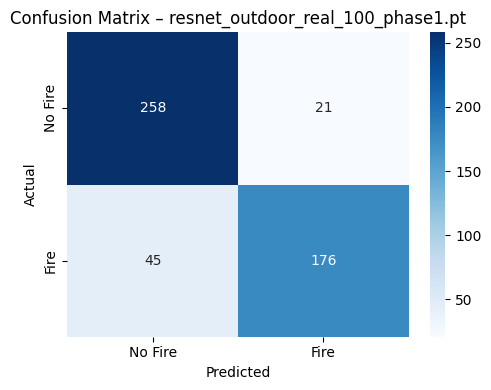


📝 Classification Report:
              precision    recall  f1-score   support

     No Fire       0.85      0.92      0.89       279
        Fire       0.89      0.80      0.84       221

    accuracy                           0.87       500
   macro avg       0.87      0.86      0.86       500
weighted avg       0.87      0.87      0.87       500



In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Ensure y_true and y_pred are numpy arrays
y_true = y_true_tensor.numpy()
y_pred = y_pred_tensor.numpy()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Fire", "Fire"],
            yticklabels=["No Fire", "Fire"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix – {model_filename}")
plt.tight_layout()

# Save confusion matrix to /figures/confusion_matrices/<TEST_SET>/
cm_dir = f"/content/drive/MyDrive/fire-detection-dissertation/figures/confusion_matrices/{test_dataset_source.upper()}/"
os.makedirs(cm_dir, exist_ok=True)

cm_filename = f"{model_filename.replace('.pt', '')}.png"
cm_path = os.path.join(cm_dir, cm_filename)
plt.savefig(cm_path)
print(f"✅ Confusion matrix saved to: {cm_path}")

plt.show()

# Print classification report
print("\n📝 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["No Fire", "Fire"]))


## 📉 Step 5: ROC Curve and AUC Score

In this step, we evaluate the model's ability to distinguish between fire and no-fire images by plotting the **Receiver Operating Characteristic (ROC) curve**.

- The ROC curve illustrates the trade-off between **True Positive Rate** (Recall) and **False Positive Rate** at various classification thresholds.
- The **AUC score** (Area Under Curve) quantifies this curve into a single value:  
  - AUC = 1.0 → Perfect separation  
  - AUC = 0.5 → Random guessing

We use the **softmax probabilities of the "Fire" class** (class 1) to compute both the ROC and AUC.  
The resulting plot is saved to a subfolder based on the test dataset, and the AUC is appended to the model's metrics `.txt` file.


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
import os
from tqdm import tqdm  # Progress bar

# Use the same labels from evaluation step
y_true = y_true_tensor.numpy()

# Collect softmax probabilities for "Fire" (class 1)
y_probs = []

model.eval()
with torch.no_grad():
    for images, _ in tqdm(test_loader, desc="🔍 Generating predictions for ROC"):
        images = images.to(device)
        outputs = model(images)
        probs = softmax(outputs, dim=1)[:, 1]  # Probability of class 1
        y_probs.extend(probs.cpu().numpy())

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_probs)
auc_score = roc_auc_score(y_true, y_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title(f"ROC Curve – {model_filename}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# Save ROC curve to figures/roc_curves/<TEST_SET>/
roc_dir = f"/content/drive/MyDrive/fire-detection-dissertation/figures/roc_curves/{test_dataset_source.upper()}/"
os.makedirs(roc_dir, exist_ok=True)

roc_filename = f"{model_filename.replace('.pt', '')}.png"
roc_path = os.path.join(roc_dir, roc_filename)
plt.savefig(roc_path)
print(f"✅ ROC curve saved to: {roc_path}")

plt.show()

# Append AUC score to metrics file
metrics_dir = f"/content/drive/MyDrive/fire-detection-dissertation/results/metrics/{test_dataset_source.upper()}/"
metrics_file = os.path.join(metrics_dir, f"{model_filename.replace('.pt', '')}.txt")
with open(metrics_file, "a") as f:
    f.write(f"AUC      : {auc_score:.4f}\n")

print(f"✅ AUC score appended to: {metrics_file}")


🔍 Generating predictions for ROC: 100%|██████████| 16/16 [00:04<00:00,  3.99it/s]


In [ ]:
# ✅ 1. Navigate to your Git-tracked directory
%cd /content/fire-detection-dissertation

# ✅ 2. Copy updated notebook from Drive into Git repo (overwrite existing)
!cp /content/drive/MyDrive/fire-detection-dissertation/notebooks/evaluate_models.ipynb /content/fire-detection-dissertation/notebooks/

# Optional: confirm it's there
!ls notebooks/

# ✅ 3. Stage changes for Git
!git add notebooks/evaluate_models.ipynb

# ✅ 4. Commit with an informative message
!git commit -m "Update evaluation notebook: added tqdm progress bar for test loop in ROC generation"

# ✅ 5. Push to GitHub
!git push


/content/fire-detection-dissertation
01_setup_environment.ipynb	 04_train_resnet_synthetic_only.ipynb
02_data_preprocessing.ipynb	 05_train_resnet_mixed_ratios.ipynb
03_train_resnet_real_only.ipynb  evaluate_models.ipynb
[main 114fed8] Update evaluation notebook: added tqdm progress bar for test loop in ROC generation
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite notebooks/evaluate_models.ipynb (97%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 64.02 KiB | 9.15 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/Misharasapu/fire-detection-dissertation.git
   a1fb8af..114fed8  main -> main
